## Contents
1. Import Libraries and Set Directory
2. Data Cleaning
    * Functions
    * Total Demand
    * Temperature
    * Forecast Demand
    * Energy Prices and Demand
    * BOM
    * Solar Installations
    * Merge Datasets
3. Exploratory Data Analysis
    * Total Demand Timeseries
    * Temperature Timeseries
    * Rain Timeseries
    * Timeseries Comparison
    * Timeseries Comparison with Kernal Smoothing

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import zipfile
import tempfile # for temporary file storage to avoid storing large datasets on github
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
base_dir = os.path.dirname(os.path.abspath("..\data"))
path = os.path.join(base_dir, r"data")
os.chdir(path)

In [ ]:
# os.listdir()

## Data Cleaning

#### Functions

In [3]:
# read zips from repo, extract data into temp dir, create dataframes
def zip_to_df(file_name):
    # create temporary directory  
    with tempfile.TemporaryDirectory() as tmpdirname:
        # collect data from zip file 
        with zipfile.ZipFile(file_name+".zip") as zip_file:
            file_list = zip_file.namelist()
            for file in file_list:
                zip_file.extract(file, tmpdirname)
            file_path = tmpdirname+"\\"+file_name
            # create and return dataframe
            df = pd.read_csv(file_path)
            return df

In [4]:
def create_date_vars(df, col, day_req=True):
    df["DATE"] = df[col].dt.date
    df["YEAR"] = df[col].dt.year
    df["MONTH"] = df[col].dt.month
    if day_req == True: df["DAY"] = df[col].dt.day
#     df["TIME"] = df[col].dt.time
#     df["HOURS"] = df[col].dt.hour
#     df["MINUTES"] = df[col].dt.minute
    return df

#### Total Demand

In [5]:
file_name = "totaldemand_nsw.csv"
totalDemand = zip_to_df(file_name)
print("Rows:", len(totalDemand))

Rows: 1323398


In [6]:
#update datatypes
totalDemand['DATETIME'] = pd.to_datetime(totalDemand['DATETIME'])

In [7]:
# create new date variables
totalDemand = create_date_vars(totalDemand, "DATETIME")

In [8]:
# remove redundant columns
totalDemand = totalDemand.drop(columns=["REGIONID"], errors='ignore')

In [9]:
# aggregate on date
totalDemandAgg = totalDemand.groupby(["YEAR","MONTH","DAY","DATE"]).mean().reset_index()
# totalDemandAgg = totalDemandAgg.drop(columns=["DATE"], errors='ignore')
print("Rows:", len(totalDemandAgg))
totalDemandAgg.head()

Rows: 4596


,YEAR,MONTH,DAY,DATE,TOTALDEMAND
0,2010,1,1,2010-01-01,7793.463681
1,2010,1,2,2010-01-02,8012.314097
2,2010,1,3,2010-01-03,7393.354514
3,2010,1,4,2010-01-04,8254.502222
4,2010,1,5,2010-01-05,8832.004931


#### Temperature

In [10]:
file_name = "temperature_nsw.csv"
temperature = zip_to_df(file_name)
print("Rows:", len(temperature))

Rows: 247646


In [11]:
#update datatypes
temperature['DATETIME'] = pd.to_datetime(temperature['DATETIME'])

In [12]:
# create new date variables
temperature = create_date_vars(temperature, "DATETIME")

In [13]:
# remove redundant columns
temperature = temperature.drop(columns=["LOCATION"], errors='ignore')

In [14]:
# aggregate on date
temperatureAgg = temperature.groupby(["YEAR","MONTH","DAY","DATE"]).mean().reset_index()
temperatureAgg = temperatureAgg.drop(columns=["DATE"], errors='ignore')
print("Rows:", len(temperatureAgg))
temperatureAgg.head()

Rows: 4593


,YEAR,MONTH,DAY,TEMPERATURE
0,2010,1,1,25.094000
1,2010,1,2,24.765385
2,2010,1,3,19.429825
3,2010,1,4,20.625926
4,2010,1,5,22.660417


#### Forecast Demand

In [15]:
file_name = "forecastdemand_nsw.csv"
forecastDemand = zip_to_df(file_name)
print("Rows:", len(forecastDemand))

Rows: 11619503


In [16]:
#update datatypes
forecastDemand['DATETIME'] = pd.to_datetime(forecastDemand['DATETIME'])
forecastDemand['LASTCHANGED'] = pd.to_datetime(forecastDemand['LASTCHANGED'])

In [17]:
# create new date variables
forecastDemand = create_date_vars(forecastDemand, "DATETIME")

In [18]:
# remove redundant columns
forecastDemand = forecastDemand.drop(columns=["REGIONID","LASTCHANGED","PREDISPATCHSEQNO","PERIODID"], errors='ignore')

In [19]:
# aggregate
forecastDemandAgg = forecastDemand.groupby(["YEAR","MONTH","DAY","DATE"]).mean().reset_index()
forecastDemandAgg = forecastDemandAgg.drop(columns=["DATE"], errors='ignore')
print("Rows:", len(forecastDemandAgg))
forecastDemandAgg.head()

Rows: 4560


,YEAR,MONTH,DAY,FORECASTDEMAND
0,2010,1,1,7747.906211
1,2010,1,2,7773.818583
2,2010,1,3,7462.384786
3,2010,1,4,8467.411400
4,2010,1,5,8784.750420


#### Energy Prices and Demand

In [20]:
#merge all files in folder
wd = path + r"\Price and Demand - 2010-22"
files = os.listdir(wd)
prices = pd.DataFrame([])
file_count = 0
for file in files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(wd + "\\" + file)
        prices = prices.append(file_df, ignore_index=True)
        file_count += 1
print("Merged", file_count, "files")

Merged 153 files


In [21]:
#remove additional headers
prices = prices[prices["REGION"]!="REGION"]
print("Rows:", len(prices))

Rows: 337488


In [22]:
#update datatypes
prices['SETTLEMENTDATE'] = pd.to_datetime(prices['SETTLEMENTDATE'])
prices['TOTALDEMAND'] = prices['TOTALDEMAND'].astype(float)
prices['RRP'] = prices['RRP'].astype(float)

In [23]:
# create new date variables
prices = create_date_vars(prices, "SETTLEMENTDATE")

In [24]:
# remove redundant columns
prices = prices.drop(columns=["REGION","PERIODTYPE"], errors='ignore')

In [25]:
# aggregate
pricesAgg = prices.groupby(["YEAR","MONTH","DAY","DATE"]).mean().reset_index()
pricesAgg = pricesAgg.drop(columns=["DATE"], errors='ignore')
print("Rows:", len(pricesAgg))
pricesAgg.head()

Rows: 4627


,YEAR,MONTH,DAY,TOTALDEMAND,RRP
0,2010,1,1,7796.317872,20.364894
1,2010,1,2,8017.459792,20.478125
2,2010,1,3,7399.899583,20.277083
3,2010,1,4,8241.720208,21.494583
4,2010,1,5,8827.813125,23.966042


#### BOM

In [26]:
# timeframe restriction
year_start = 2010

In [27]:
file_path = path + r"\Solar Exposure - Bankstown Airport\IDCJAC0016_066137_1800_Data.csv"
bomSolar = pd.read_csv(file_path)
bomSolar = bomSolar[bomSolar.Year >= year_start]
print("Rows:", len(bomSolar))

Rows: 4816


In [28]:
file_path = path + r"\Temperature - Bankstown Airport\IDCJAC0011_066137_1800_Data_Daily_Min_Temp.csv"
bomTempMin = pd.read_csv(file_path)
bomTempMin = bomTempMin[bomTempMin.Year >= year_start]
print("Rows:", len(bomTempMin))

Rows: 4830


In [29]:
file_path = path + r"\Temperature - Bankstown Airport\IDCJAC0010_066137_1800_Data_Daily_Max_Temp.csv"
bomTempMax = pd.read_csv(file_path)
bomTempMax = bomTempMax[bomTempMax.Year >= year_start]
print("Rows:", len(bomTempMax))

Rows: 4816


In [30]:
file_path = path + r"\Rainfall - Bankstown\IDCJAC0009_066137_1800_Data.csv"
bomRain = pd.read_csv(file_path)
bomRain = bomRain[bomRain.Year >= year_start]
print("Rows:", len(bomRain))

Rows: 4817


In [31]:
# remove redundant columns
bomSolar = bomSolar.drop(columns=["Product code","Bureau of Meteorology station number"], errors='ignore')
bomTempMin = bomTempMin.drop(columns=["Product code","Bureau of Meteorology station number","Quality"], errors='ignore')
bomTempMax = bomTempMax.drop(columns=["Product code","Bureau of Meteorology station number","Quality"], errors='ignore')
bomRain = bomRain.drop(columns=["Product code","Bureau of Meteorology station number","Quality"], errors='ignore')

In [32]:
# merge bom datasets and rename headers
bom = bomTempMin.merge(bomTempMax, how="left", on=["Year","Month","Day"])
bom = bom.merge(bomRain, how="left", on=["Year","Month","Day"])
bom = bom.merge(bomSolar, how="outer", on=["Year","Month","Day"])
bom.columns = ['YEAR','MONTH','DAY',"MIN", "ACCMIN", 'MAX','ACCMAX','RAIN','RAINPERIOD','SOLAR']
print("Rows:", len(bom))
bom.head()

Rows: 4830


,YEAR,MONTH,DAY,MIN,ACCMIN,MAX,ACCMAX,RAIN,RAINPERIOD,SOLAR
0,2010,1,1,20.3,1.0,29.6,1.0,0.2,1.0,14.6
1,2010,1,2,22.2,1.0,29.5,1.0,0.0,1.0,18.4
2,2010,1,3,18.5,1.0,21.0,1.0,15.2,1.0,7.3
3,2010,1,4,17.8,1.0,24.0,1.0,0.2,1.0,14.4
4,2010,1,5,16.2,1.0,30.4,1.0,0.0,1.0,28.1


#### Solar Panels

In [126]:
#merge all files in folder
wd = path + r"\Solar Panel Installations - Bankstown"
files = os.listdir(wd)
sguSolar = pd.DataFrame([])
file_count = 0
for file in files:
    if file.endswith(".csv"):
        sgu = pd.read_csv(wd + "\\" + file)
        sgu = sgu[sgu["Small Unit Installation Postcode"]==2200]
        sgu = pd.melt(sgu, id_vars='Small Unit Installation Postcode')
        sgu = sgu[~sgu["variable"].str.contains("Previous Years")]
        sgu = sgu[~sgu["variable"].str.contains("Total")]
        sgu["Col"] = np.where(sgu["variable"].str.contains("Quantity"), "Quantity", "Output")
        sgu["variable"] = sgu["variable"].str.split('-').str[0]
        sgu["value"] = sgu["value"].astype(float)
        sgu = pd.pivot_table(sgu, values="value", columns="Col", index=["Small Unit Installation Postcode", "variable"]).reset_index()
        sguSolar = sguSolar.append(sgu, ignore_index=True, sort=False)
        file_count += 1
print("Merged", file_count, "files")
print("Rows:", len(sguSolar))

Merged 12 files
Rows: 278


In [127]:
# update datatypes
sguSolar["DATETIME"] = pd.to_datetime(sguSolar["variable"])

In [128]:
# remove redundant columns
sguSolar = sguSolar.drop(columns=["Small Unit Installation Postcode","variable"], errors='ignore')

In [129]:
# rename columns
sguSolar.columns = ["OUTPUT","QUANTITY","DATETIME"]

In [130]:
# create new date variables
sguSolar = create_date_vars(sguSolar, "DATETIME", day_req=False)

In [131]:
# calculate cumulative sum, ordered by date
sguSolar = sguSolar.sort_values(['DATE'], ascending=[True])
# sguSolar["QUANTITYMONTHCUM"] = sguSolar.groupby(['DATE'])['QUANTITY'].cumsum(axis=0)
# sguSolar["QUANTITYTOTALCUM"] = sguSolar['QUANTITY'].cumsum(axis=0)
sguSolar = sguSolar.drop(columns=["DATETIME","DATE"], errors='ignore')
print("Rows:", len(sguSolar))
sguSolar.head()

Rows: 278


,OUTPUT,QUANTITY,YEAR,MONTH
8,0.00,0.0,2009,1
6,0.00,0.0,2009,2
14,0.00,0.0,2009,3
0,0.99,1.0,2009,4
16,1.00,1.0,2009,5


In [133]:
sguSolarAgg = sguSolar.groupby(["YEAR","MONTH"]).sum().reset_index()
sguSolarAgg.head()

,YEAR,MONTH,OUTPUT,QUANTITY
0,2009,1,0.00,0.0
1,2009,2,0.00,0.0
2,2009,3,0.00,0.0
3,2009,4,0.99,1.0
4,2009,5,1.00,1.0


#### Humidity and Wind

In [135]:
#merge all files in folder
wd = path + r"\Weather - timeanddate"
files = os.listdir(wd)
weather = pd.DataFrame([])
file_count = 0
for file in files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(wd + "\\" + file)
        weather = weather.append(file_df, ignore_index=True, sort=False)
        file_count += 1
weather = weather.iloc[:,1:]
print("Merged", file_count, "files")

Merged 7 files


In [136]:
# remove nulls
weather = weather[~weather["HUMIDITY"].str.contains("mbar", na=False)]
weather = weather.dropna()

In [137]:
# update datatypes
weather["DATETIME"] = pd.to_datetime(weather["DATE"])

In [138]:
# create new date variables
weather = create_date_vars(weather, "DATETIME")

In [139]:
# remove redundant columns
weather = weather.drop(columns=["DATE","DATETIME","TIME","WINDDIRECTION","BAROMETER"], errors='ignore')

In [140]:
# remove null rows
weather = weather.dropna()

In [141]:
# clean columns
weather["HUMIDITY"] = weather["HUMIDITY"].str.split('%', expand=True)[0]
weather["HUMIDITY"] = weather["HUMIDITY"].astype(int) / 100
weather["TEMP"] = weather["TEMP"].map(lambda x: str(x)[:-2]).astype(float)
weather["WINDSPEED"] = weather["WINDSPEED"].replace("No wind", 0)
weather["WINDSPEED"] = weather["WINDSPEED"].str.split(' km/h', expand=True)[0].astype(float)
weather = weather[["YEAR","MONTH","DAY","HUMIDITY","WINDSPEED"]]

In [142]:
weatherAgg = weather.groupby(["YEAR","MONTH","DAY"]).mean().reset_index()
weatherAgg.head() 

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED
0,2016,1,1,0.656341,15.902439
1,2016,1,2,0.656341,15.902439
2,2016,1,3,0.688837,14.488372
3,2016,1,4,0.679545,22.477273
4,2016,1,5,0.768837,22.581395


#### Public Holidays

In [47]:
#merge all files in folder
wd = path + r"\Public Holidays"
files = os.listdir(wd)
holidays = pd.DataFrame([])
file_count = 0
for file in files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(wd + "\\" + file)
        try: file_df["Jurisdiction"] = file_df["Applicable To"]
        except: pass
        file_df = file_df[["Date","Jurisdiction"]]
        holidays = holidays.append(file_df, ignore_index=True, sort=False)
        file_count += 1
print("Merged", file_count, "files")

Merged 7 files


In [48]:
# update data type
holidays['Date'] = holidays['Date'].astype(str)

In [49]:
# create date variables
holidays['YEAR'] = holidays['Date'].str[:4].astype(int)
holidays['MONTH'] = holidays['Date'].str[4:6].astype(int)
holidays['DAY'] = holidays['Date'].str[6:].astype(int)

In [50]:
# unpack jurisdiction values and filter to NSW only
holidays['Jurisdiction'] = holidays['Jurisdiction'].str.split('|')
holidays = holidays.explode('Jurisdiction')
holidays['Jurisdiction'] = holidays['Jurisdiction'].str.upper()
holidays['Jurisdiction'] = holidays['Jurisdiction'].str.replace('NAT','NSW') 
holidays = holidays[(holidays['Jurisdiction']=="NSW")]
holidays = holidays.drop(columns=["Date","Jurisdiction"])

In [103]:
# holiday count
holidays["HOLIDAY"] = 1
holidays = holidays.groupby(["YEAR","MONTH","DAY"]).count().reset_index()
holidays

,YEAR,MONTH,DAY,HOLIDAY
0,2015,1,1,1
1,2015,1,26,1
2,2015,4,3,1
3,2015,4,4,1
4,2015,4,5,1
...,...,...,...,...
109,2023,6,12,1
110,2023,8,7,1
111,2023,10,2,1
112,2023,12,25,1


#### Merge All Datasets

In [147]:
df = totalDemandAgg.merge(holidays, how="left", on=["YEAR","MONTH","DAY"])
df = weatherAgg.merge(df, how="right", on=["YEAR","MONTH","DAY"])
df = df.merge(bom, how="left", on=["YEAR","MONTH","DAY"])
df = df.merge(pricesAgg, how="left", on=["YEAR","MONTH","DAY"])
df = df.merge(forecastDemandAgg, how="left", on=["YEAR","MONTH","DAY"])
df = df.merge(sguSolarAgg, how="left", on=["YEAR","MONTH"])
df = df[df["YEAR"]>=2016]
df["HOLIDAY"] = df["HOLIDAY"].fillna(0)
print("Rows:", len(df))
df = df.sort_values("DATE")
df.head() 

Rows: 2405


,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND_x,HOLIDAY,MIN,ACCMIN,MAX,ACCMAX,RAIN,RAINPERIOD,SOLAR,TOTALDEMAND_y,RRP,FORECASTDEMAND,OUTPUT,QUANTITY
2191,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,1.0,15.3,1.0,28.6,1.0,0.0,1.0,32.2,6861.518333,38.472917,6665.366167,46.93,10.0
2192,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,15.9,1.0,26.1,1.0,0.0,1.0,21.7,6731.957292,36.907292,6236.849955,46.93,10.0
2193,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,17.5,1.0,25.6,1.0,0.0,1.0,10.3,6618.040000,31.997083,6551.924748,46.93,10.0
2194,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,18.2,1.0,23.6,1.0,14.0,1.0,6.4,7358.550000,33.424583,6729.993123,46.93,10.0
2195,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,17.6,1.0,20.5,1.0,39.0,1.0,4.4,7460.061875,33.053958,7333.898202,46.93,10.0


In [148]:
# add month date column
df['MONTHDATE'] = df['MONTH'].map(str)+ '-' +df['YEAR'].map(str)
df['MONTHDATE'] = pd.to_datetime(df['MONTHDATE'], format='%m-%Y').dt.strftime('%m-%Y')

In [149]:
# add week day column
df['DATE'] = pd.to_datetime(df['DATE'],format="%Y-%m-%d")
df["WEEKDAY"] = df["DATE"].dt.dayofweek
df["WEEKEND"] = np.select([df["WEEKDAY"]>4], [1], 0)

In [150]:
# create average temperature
df["TEMPAVE"] = (df["MIN"] + df["MAX"]) / 2

In [151]:
# remove duplicate TOTALDEMAND column and rename
df = df.drop(columns=["TOTALDEMAND_y"], errors="ignore")
df = df.rename(columns={'TOTALDEMAND_x': 'TOTALDEMAND'})

In [152]:
# check for nulls
df.isna().sum()

YEAR                0
MONTH               0
DAY                 0
HUMIDITY            1
WINDSPEED           1
DATE                0
TOTALDEMAND         0
HOLIDAY             0
MIN                 9
ACCMIN              9
MAX                13
ACCMAX             13
RAIN               55
RAINPERIOD         55
SOLAR               1
RRP                 0
FORECASTDEMAND     36
OUTPUT            365
QUANTITY          365
MONTHDATE           0
WEEKDAY             0
WEEKEND             0
TEMPAVE            17
dtype: int64

In [153]:
# solar panel installations missing data for 2021 - remove this year for now
# remove rows with empty forecast demand, solar, temperatures
# replace nulls in rain columns with 0
df = df.dropna(axis=0, subset=['OUTPUT','SOLAR','MAX','FORECASTDEMAND'])
df = df.fillna(0)
df.isna().sum()

YEAR              0
MONTH             0
DAY               0
HUMIDITY          0
WINDSPEED         0
DATE              0
TOTALDEMAND       0
HOLIDAY           0
MIN               0
ACCMIN            0
MAX               0
ACCMAX            0
RAIN              0
RAINPERIOD        0
SOLAR             0
RRP               0
FORECASTDEMAND    0
OUTPUT            0
QUANTITY          0
MONTHDATE         0
WEEKDAY           0
WEEKEND           0
TEMPAVE           0
dtype: int64

In [156]:
# remove unnessecary columns
df = df.drop(columns=["ACCMAX","ACCMIN","RAINPERIOD","QUANTITY"],errors="ignore")
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,MIN,MAX,RAIN,SOLAR,RRP,FORECASTDEMAND,OUTPUT,MONTHDATE,WEEKDAY,WEEKEND,TEMPAVE
2191,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,1.0,15.3,28.6,0.0,32.2,38.472917,6665.366167,46.93,01-2016,4,0,21.95
2192,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,15.9,26.1,0.0,21.7,36.907292,6236.849955,46.93,01-2016,5,1,21.00
2193,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,17.5,25.6,0.0,10.3,31.997083,6551.924748,46.93,01-2016,6,1,21.55
2194,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,18.2,23.6,14.0,6.4,33.424583,6729.993123,46.93,01-2016,0,0,20.90
2195,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,17.6,20.5,39.0,4.4,33.053958,7333.898202,46.93,01-2016,1,0,19.05


In [157]:
# save cleaned and merged dataset as csv
target_dir = os.getcwd() + "\\Cleaned data\\"
df.to_csv(target_dir+"data.csv",index=False)

## Exploratory Data Analysis

In [158]:
df.describe()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,MIN,MAX,RAIN,SOLAR,RRP,FORECASTDEMAND,OUTPUT,WEEKDAY,WEEKEND,TEMPAVE
count,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.00000,1990.000000
mean,2018.412563,6.273367,15.773869,0.676574,20.429919,7938.569881,0.034673,12.714322,24.503668,2.854171,16.014322,91.168926,7888.567378,172.349920,3.000503,0.28593,18.582864
std,1.821370,3.436656,8.779640,0.139368,6.728314,782.190213,0.182997,5.755622,5.665890,10.695274,7.113749,90.664972,770.702974,151.391422,1.999623,0.45197,5.277815
min,2016.000000,1.000000,1.000000,0.000000,0.000000,6035.576076,0.000000,-1.400000,12.300000,0.000000,1.000000,23.908333,5518.989111,24.640000,0.000000,0.00000,0.000000
25%,2017.000000,3.000000,8.000000,0.593880,15.222917,7390.108099,0.000000,8.000000,20.000000,0.000000,10.800000,52.180573,7345.926781,72.780000,1.000000,0.00000,14.100000
50%,2018.000000,6.000000,16.000000,0.690231,19.328991,7846.320451,0.000000,13.100000,24.200000,0.000000,14.650000,75.003750,7816.133609,127.200000,3.000000,0.00000,18.750000
75%,2020.000000,9.000000,23.000000,0.777609,24.399517,8497.666267,0.000000,17.500000,28.000000,0.400000,21.400000,93.008333,8454.892596,221.030000,5.000000,1.00000,22.437500
max,2022.000000,12.000000,31.000000,0.965091,47.857143,10851.752604,1.000000,28.100000,47.000000,159.600000,32.200000,1539.430000,10751.957092,916.710000,6.000000,1.00000,34.400000


#### Timeseries

In [159]:
df_lim = df[df["YEAR"]>2020]

In [161]:
# set variables
xDate = df_lim.DATE
xMonth = df_lim['MONTHDATE']
yTemp = df_lim.MAX
yDemand = df_lim.TOTALDEMAND
yRain = df_lim.RAIN
ySolar = df_lim.SOLAR 
# yPanels = df_lim.QUANTITYTOTALCUM

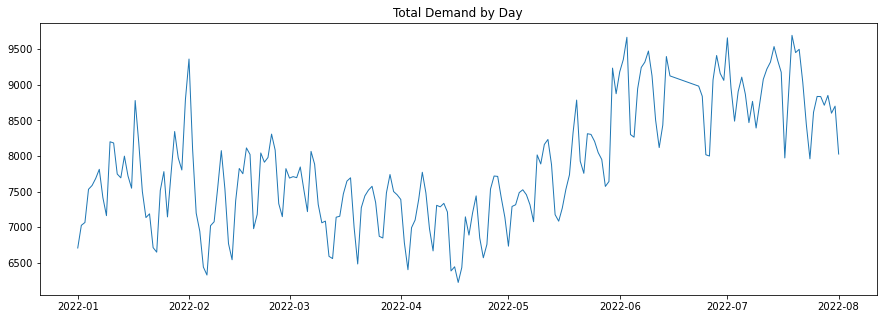

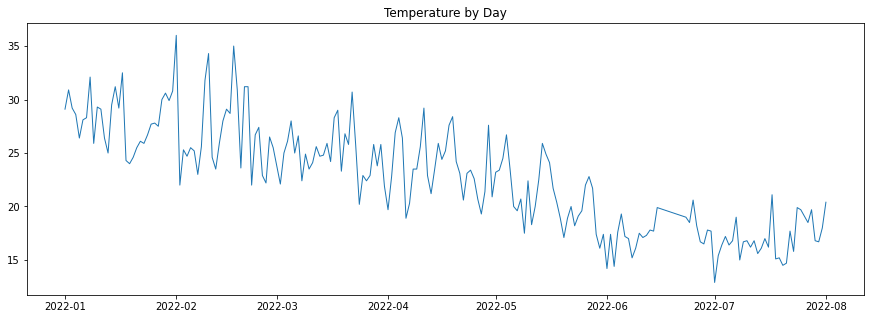

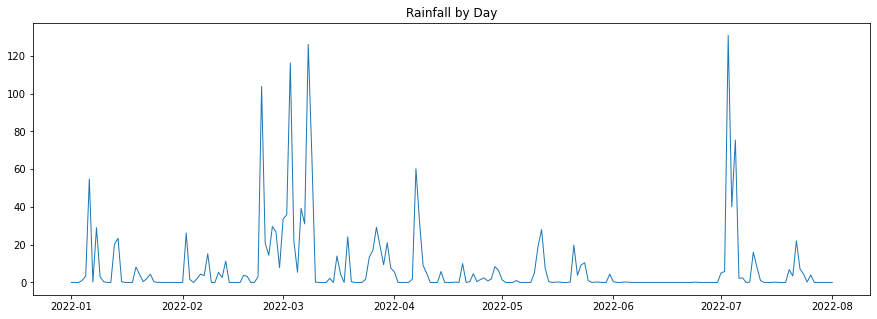

In [162]:
# Demand
plt.figure(figsize=(15,5))
plt.plot(xDate, yDemand, linewidth=1)
plt.title("Total Demand by Day")
plt.show() 

# Temperature
plt.figure(figsize=(15,5))
plt.plot(xDate, yTemp, linewidth=1)
plt.title("Temperature by Day")
plt.show() 

# Rain
plt.figure(figsize=(15,5))
plt.plot(xDate, yRain, linewidth=1)
plt.title("Rainfall by Day")
plt.show() 

# # Cumulative Solar Panel Installations (monthly)
# plt.figure(figsize=(15,5))
# plt.plot(xMonth, yPanels, linewidth=1)
# plt.title("Cumulative Solar Panel Installations by Month")
# plt.show() 

#### Smoothing

In [163]:
# df_lim = df[df["YEAR"]>2020]
df_agg = df.groupby(['MONTHDATE']).mean().reset_index()

In [164]:
# update date types
df_agg['MONTHDATE'] = pd.to_datetime(df_agg.MONTHDATE)
df_agg = df_agg.sort_values("MONTHDATE")

In [165]:
# set variables
xDate = df_agg.MONTHDATE
xMonth = df_agg.MONTHDATE
yTemp = df_agg.MAX
yDemand = df_agg.TOTALDEMAND
yRain = df_agg.RAIN
ySolar = df_agg.SOLAR 
# yPanels = df_agg.QUANTITYTOTALCUM

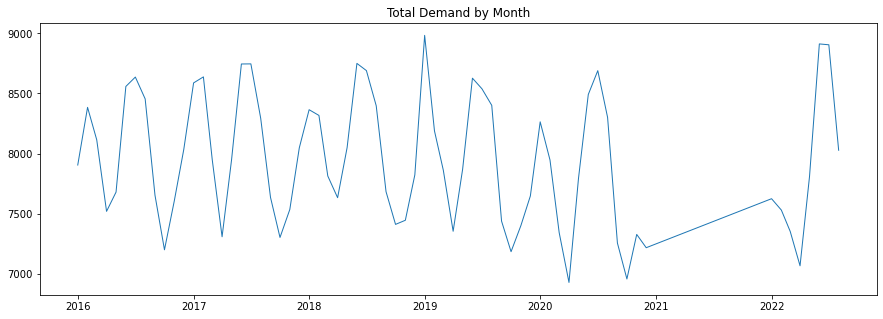

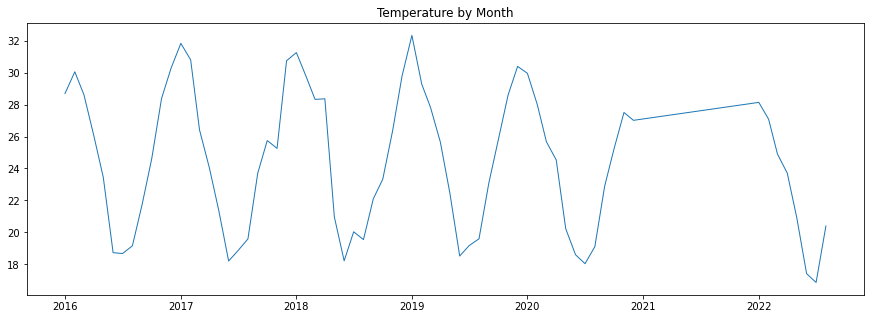

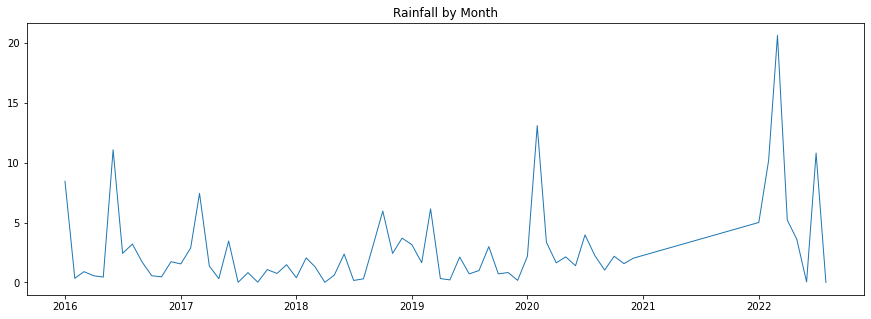

In [166]:
# Demand
plt.figure(figsize=(15,5))
plt.plot(xDate, yDemand, linewidth=1)
plt.title("Total Demand by Month")
plt.show() 

# Temperature
plt.figure(figsize=(15,5))
plt.plot(xDate, yTemp, linewidth=1)
plt.title("Temperature by Month")
plt.show() 

# Rain
plt.figure(figsize=(15,5))
plt.plot(xDate, yRain, linewidth=1)
plt.title("Rainfall by Month")
plt.show() 

# # Cumulative Solar Panel Installations (monthly)
# plt.figure(figsize=(15,5))
# plt.plot(xMonth, yPanels, linewidth=1)
# plt.title("Cumulative Solar Panel Installations by Month (2021 data missing)")
# plt.show() 

#### Correlation Analysis

In [167]:
import seaborn as sns

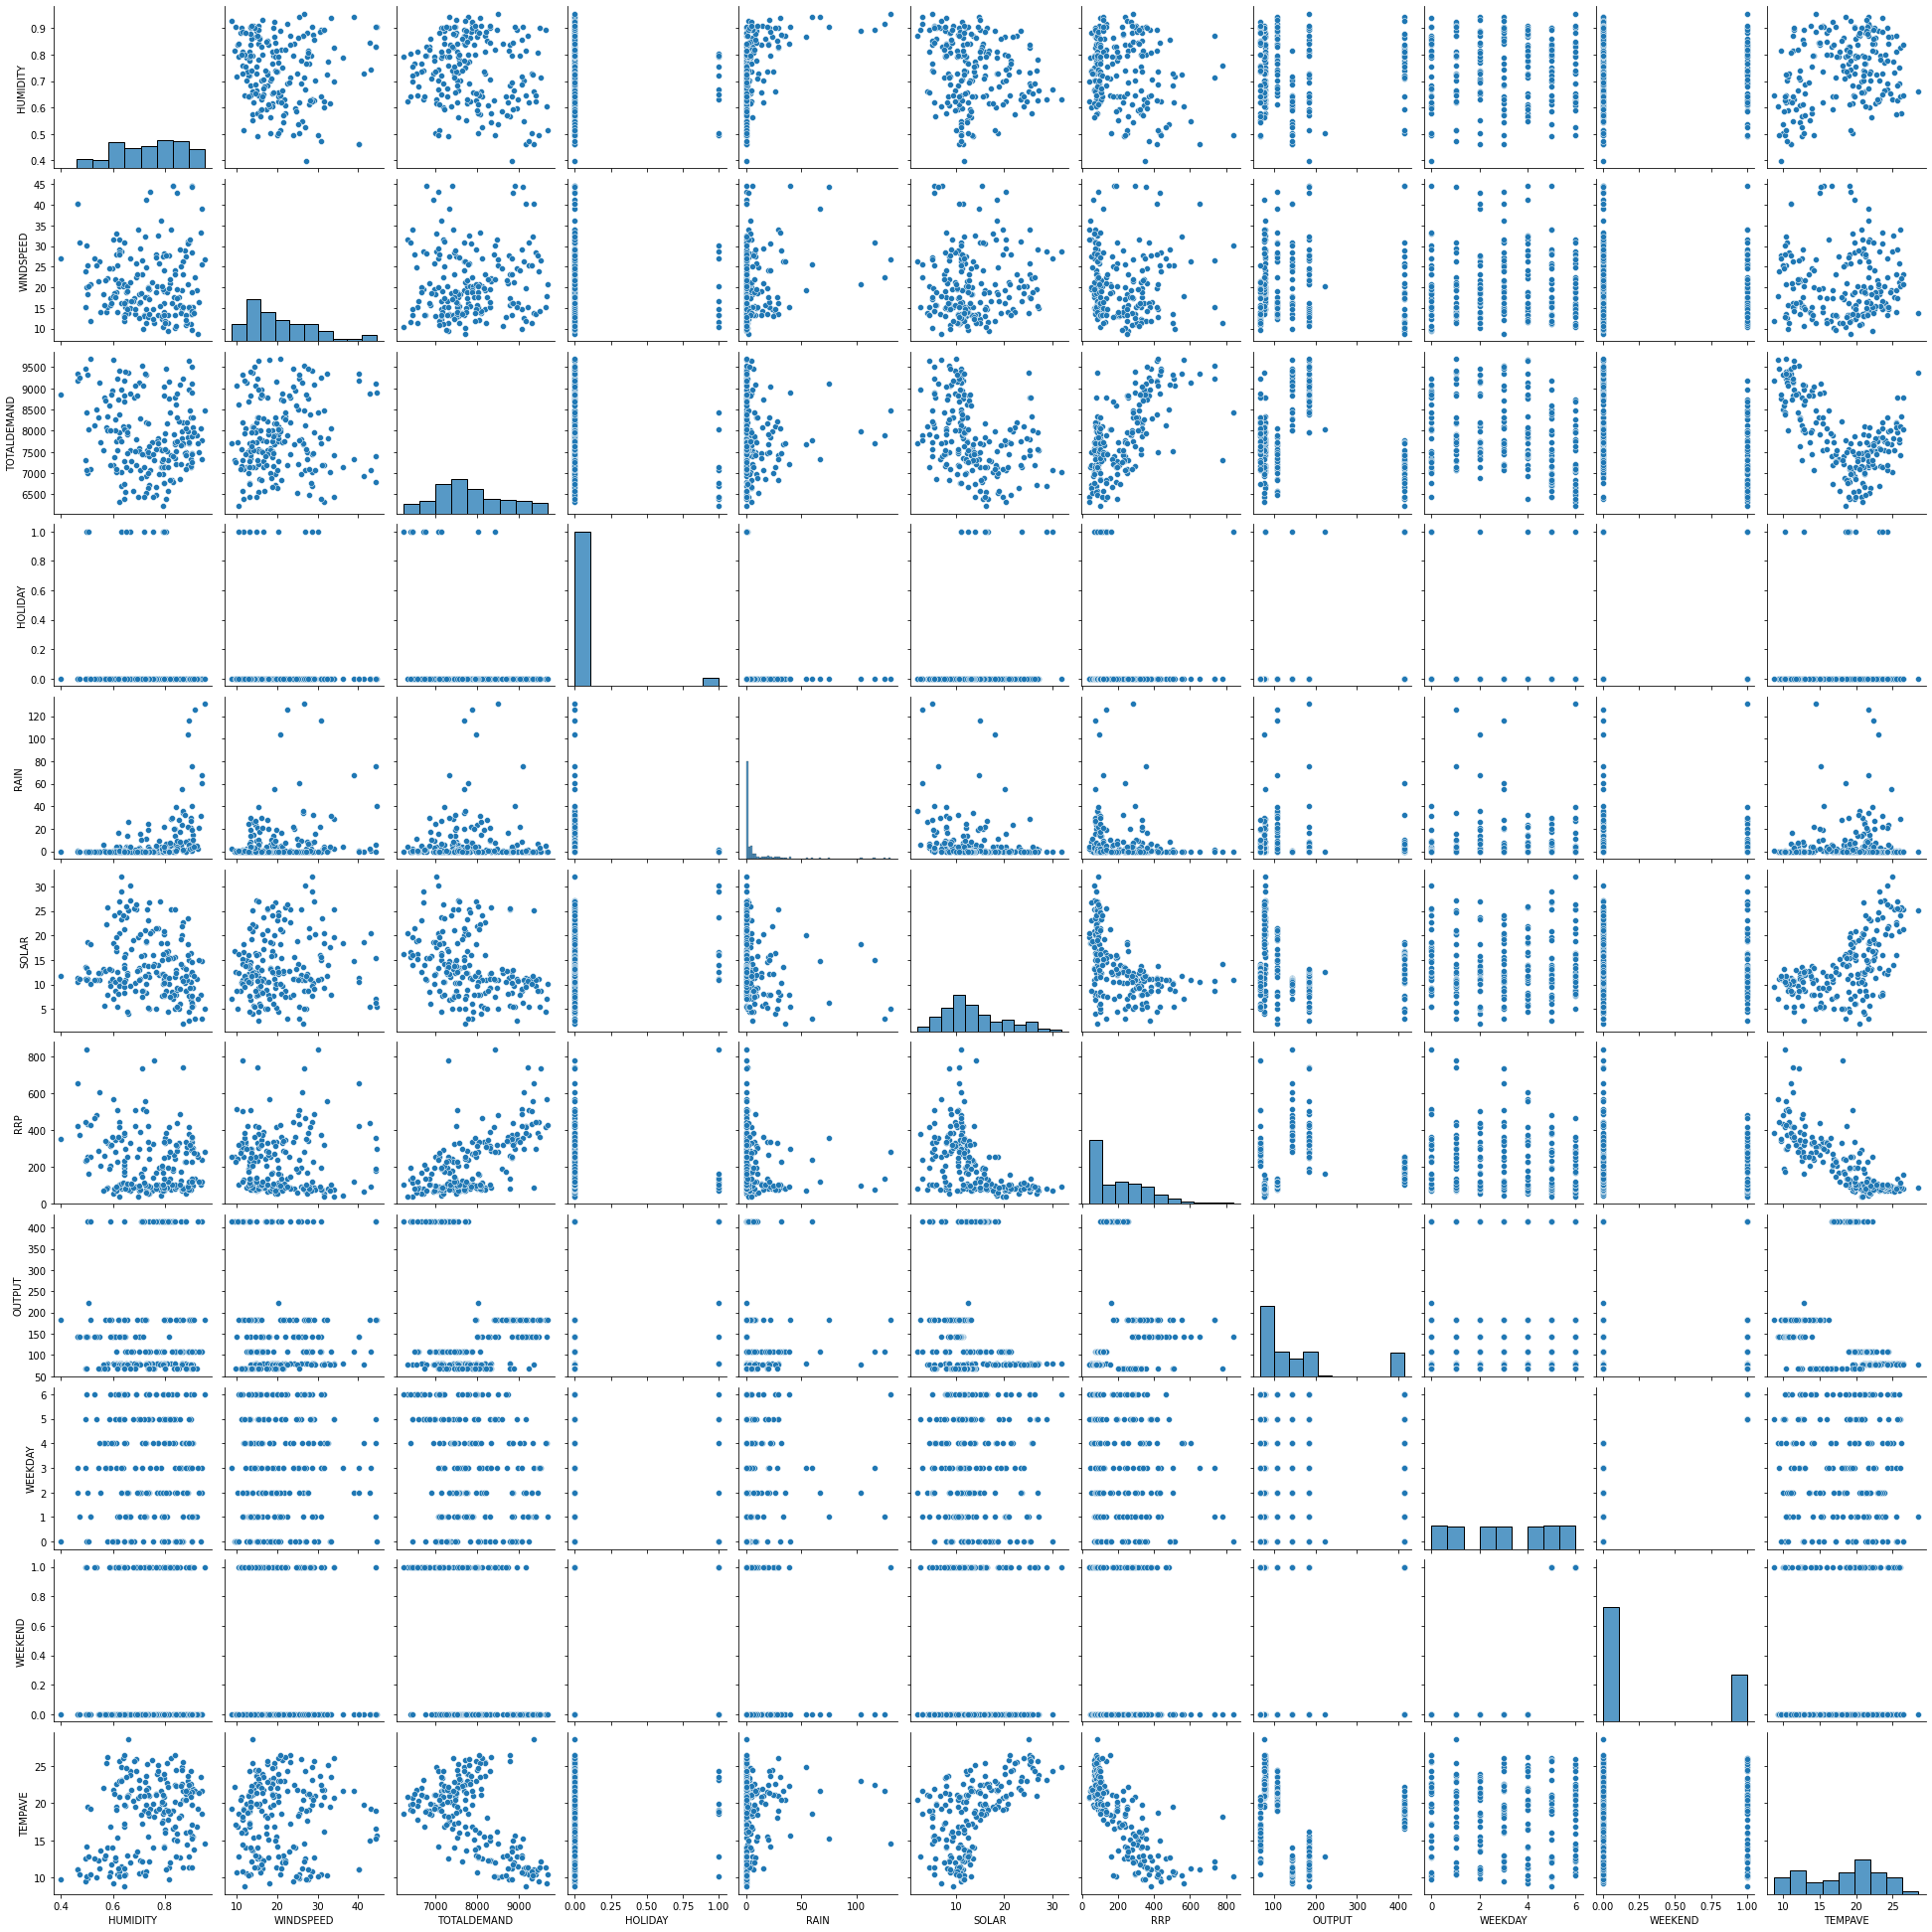

In [173]:
pp_df = df[df["YEAR"]==2022]
pp_df = pp_df[["HUMIDITY","WINDSPEED","TOTALDEMAND","HOLIDAY","RAIN","SOLAR","RRP","OUTPUT","WEEKDAY","WEEKEND","TEMPAVE"]]
sns.pairplot(pp_df) 